In [1]:
!pip install nltk
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [3]:
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk import word_tokenize
from wordcloud import WordCloud

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
with open('drive/MyDrive/Diplom/test.csv') as f:
    test = pd.read_csv(f,sep='\t')
with open('drive/MyDrive/Diplom/train.csv') as f:
    train = pd.read_csv(f,sep='\t')

In [11]:
ds = pd.concat([train,test], ignore_index=True) 

# Визуализация текста

 Частота количества слов в комментариях.

<Axes: ylabel='Frequency'>

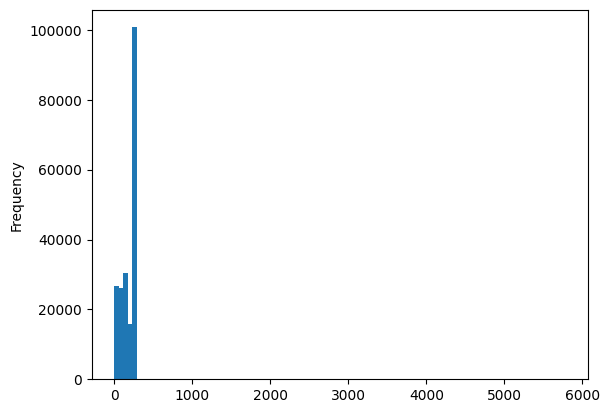

In [ ]:
ds['body_length'].plot(kind='hist', bins = 100)

In [ ]:
print('Average', ds['body_length'].mean())
print('Max', ds['body_length'].max())
print('Min', ds['body_length'].min())

Average 179.44152987984086
Max 5781
Min 1


В среднем 180 слов в комментарии.

Для визуализации комментариев используется прием - wordcloud. Это картинка со словами, в которой размер слова, связан с частотой встречаемости его в тексте. Чем больше частота, тем крупнее слово и наоборот. Используя этот прием, можно проанализировать состав комментариев и определить слова, которые часто повторяются, но не дают никакого понимания о классе комментария. 


In [ ]:
word_cloud_cloud = ''.join(ds['body'])

<function matplotlib.pyplot.show(close=None, block=None)>

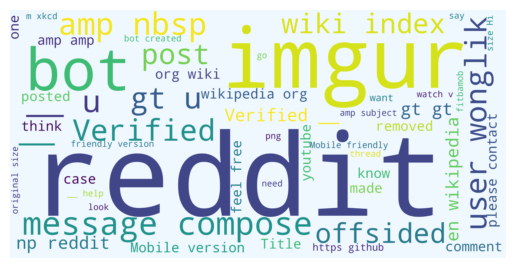

In [ ]:
picture = WordCloud(max_words = 50,
                    background_color = 'aliceblue',
                    scale = 10).generate(word_cloud_cloud)
plt.figure
plt.imshow(picture, interpolation = 'bilinear')
plt.axis('off')
plt.show

Можно видеть, что в тексте у нас присутствуют символы ('gt') из html кода старницы, есть аббревиатуры расширеший ('png'), сокращения ('org', 'en', 'u') и слова без эмоциональной окраски или оценки ('Hi', 'know', 'go') и т.д. Самыми крупными словами здесь являются: 'reddit' - сервис-источник комментариев, 'imgur' - сайт, где делятся изображениями, 'bot' - программа выполняющая заданные действия.

# NLP

1. Перевод текста в нижний регистр
2. Удаление особых символов
3. Удаление стоп-слов и слишком часто/редко встречающихся слов
4. Стемминг/лемматизация

In [ ]:
train['body_low'] = train['body'].str.lower()
test['body_low'] = test['body'].str.lower()

In [ ]:
def delt(x):
    return re.sub(r'[^A-Za-z0-9 ]+', " ", x)


train['body_clean'] = train['body_low'].apply(lambda x: delt(x))
test['body_clean'] = test['body_low'].apply(lambda x: delt(x))

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['    ', 'com', 'r', 'u', 'gt', 'www','1', 'png', 'comment','post', 'amp','nbsp', 'xkcd', '009', 'np',
       'tag', 'http np', 'watch','like', 'people', 'one', 'think', 'good', 'get', 'know', 'time','well', 'really', 'right', 'make','see','thing', 'look', 'great', 'much', 'want','still', 'way','v'])

TF-IDF

Для элемента i в комментарии j : $w_{i,j} = tf_{i,j}×log(\frac{N}{df_{i}})$ , $tf_{i,j}$ - количество появлений i в j, $df_{i}$ - количество комментариев, содержащих i, N - общее количество комментариев.

In [ ]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

tfidf_counts_NLTK = TfidfVectorizer(lowercase = True,
                               tokenizer=tokenizer,
                               stop_words = token_stop,
                               ngram_range=(1,2),
                               max_df=5000,
                               min_df=70)

train_tfidf = tfidf_counts_NLTK.fit_transform(train['body_clean'])
test_tfidf = tfidf_counts_NLTK.transform(test['body_clean'])
print(f"n_samples: {train_tfidf.shape[0]}, n_features: {train_tfidf.shape[1]}")
print(f"n_samples: {test_tfidf.shape[0]}, n_features: {test_tfidf.shape[1]}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


n_samples: 197068, n_features: 6669
n_samples: 3000, n_features: 6669


In [ ]:
importance = np.argsort(np.asarray(train_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_counts_NLTK.get_feature_names_out())
tfidf_feature_names[importance[:10]]

array(['gif', 'wonglik', 'user wonglik', 'offsided', 'word', 'year',
       'reply', 'made', 'game', 'tip'], dtype=object)

In [ ]:
bots = train[train.Y == 0]

bots['body_low'] = bots['body'].str.lower()
bots['body_clean'] = bots['body_low'].apply(lambda x: delt(x))

tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

tfidf_counts_NLTK = TfidfVectorizer(lowercase = True,
                               tokenizer=tokenizer,
                               stop_words = token_stop,
                               ngram_range=(1,2),
                               max_df=5000,
                               min_df=100)

bots_tfidf = tfidf_counts_NLTK.fit_transform(bots['body_clean'])
print(f"n_samples: {bots_tfidf.shape[0]}, n_features: {bots_tfidf.shape[1]}")

<ipython-input-20-8b69e7ada28b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bots['body_low'] = bots['body'].str.lower()
<ipython-input-20-8b69e7ada28b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bots['body_clean'] = bots['body_low'].apply(lambda x: delt(x))
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


n_samples: 162605, n_features: 4912


In [ ]:
importance = np.argsort(np.asarray(bots_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_counts_NLTK.get_feature_names_out())
tfidf_feature_names[importance[:10]]

array(['gif', 'wonglik', 'user wonglik', 'offsided', 'text', 'word',
       'reply', 'tip', 'github', 'please contact'], dtype=object)

In [ ]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:
trolls = train[train.Y == 1]

trolls['body_low'] = trolls['body'].str.lower()
trolls['body_clean'] = trolls['body_low'].apply(lambda x: delt(x))

tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

tfidf_counts_NLTK = TfidfVectorizer(lowercase = True,
                               tokenizer=tokenizer,
                               stop_words = token_stop,
                               ngram_range=(1,2),
                               max_df=5000,
                               min_df=50)

trolls_tfidf = tfidf_counts_NLTK.fit_transform(trolls['body_clean'])
print(f"n_samples: {trolls_tfidf.shape[0]}, n_features: {trolls_tfidf.shape[1]}")

<ipython-input-38-ead031ffaa4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trolls['body_low'] = trolls['body'].str.lower()
<ipython-input-38-ead031ffaa4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trolls['body_clean'] = trolls['body_low'].apply(lambda x: delt(x))
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


n_samples: 4499, n_features: 73


In [ ]:
importance = np.argsort(np.asarray(trolls_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_counts_NLTK.get_feature_names_out())
tfidf_feature_names[importance[:10]]

array(['tie', 'even', 'love', 'news', 'never', 'go', 'guy', 'first',
       'thanks', 'day'], dtype=object)

In [ ]:
norms = train[train.Y == 2]

norms['body_low'] = norms['body'].str.lower()
norms['body_clean'] = norms['body_low'].apply(lambda x: delt(x))

tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

tfidf_counts_NLTK = TfidfVectorizer(lowercase = True,
                               tokenizer=tokenizer,
                               stop_words = token_stop,
                               ngram_range=(1,2),
                               max_df=5000,
                               min_df=100)

norms_tfidf = tfidf_counts_NLTK.fit_transform(norms['body_clean'])
print(f"n_samples: {norms_tfidf.shape[0]}, n_features: {norms_tfidf.shape[1]}")

<ipython-input-24-b5edbd0c7f8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norms['body_low'] = norms['body'].str.lower()
<ipython-input-24-b5edbd0c7f8f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norms['body_clean'] = norms['body_low'].apply(lambda x: delt(x))


n_samples: 29964, n_features: 375


In [ ]:
importance = np.argsort(np.asarray(norms_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_counts_NLTK.get_feature_names_out())
tfidf_feature_names[importance[:10]]

array(['game', 'got', 'go', 'thanks', 'even', 'also', 'yeah', 'work',
       'sure', 'year'], dtype=object)

# SpaCy

In [ ]:
import spacy
# Create a spacy natural-language processor for English
nlp = spacy.load('en_core_web_sm')

doc = nlp(ds['body'][30896])

print("Sentence: ", doc, "\n")

for token in doc[:1]:
    print("               original |", token.orth_)
    print("                  lemma |", token.lemma_)
    print("        is punctuation? |", token.is_punct)
    print("            is numeric? |", token.is_digit)
    print("         is a stopword? |", token.is_stop)
    print("         part of speech |", token.pos_)
    print("           detailed POS |", token.tag_)
    print("")

Sentence:  Comment Removed. Reason : Steam gifts inventory is set to private, [set your gifts inventory to public](http://i.imgur.com/0VHZkNd.png) &gt;**I'm a bot working for /r/SteamGameSwap. If you think this removal is a mistake, please [message the moder 

               original | Comment
                  lemma | comment
        is punctuation? | False
            is numeric? | False
         is a stopword? | False
         part of speech | NOUN
           detailed POS | NN



In [ ]:
import spacy
# Create a spacy natural-language processor for English
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    doc = nlp(text)
    # Turn it into tokens, ignoring the punctuation
    tokens = [token for token in doc if not token.is_punct]
    # Convert those tokens into lemmas, EXCEPT the pronouns, we'll keep those.
    lemmas = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokens]
    return lemmas


tfidf_counts_spaCy = TfidfVectorizer(lowercase = True, 
                               tokenizer=lemmatize, 
                               stop_words=stop_words, 
                               max_df=5000,
                               min_df=70,
                               use_idf=True, 
                               norm='l1')

tfidf_data = tfidf_counts_spaCy.fit_transform(train['body_clean'])
tfidf_data.shape

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'ve", 'could', 'far', 'http', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.
  warnings.warn(


(197068, 3296)

In [ ]:
importance = np.argsort(np.asarray(tfidf_data.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_counts_spaCy.get_feature_names_out())
tfidf_feature_names[importance[:10]]

array(['imgur', 'bot', 'https', 'please', 'wiki', '    ', 'link',
       'verify', 'video', 'say'], dtype=object)

#Добавление фичей

In [8]:
import re

words_all = ['gif', 'wonglik', 'user wonglik', 'offsided', 'word', 'year',
       'reply', 'made', 'game', 'tip']

words_bots = ['gif', 'wonglik', 'user wonglik', 'offsided', 'text', 'word',
       'reply', 'tip', 'github', 'please contact']

words_trolls = ['tie', 'love', 'news', 'never','guy', 'first', 'day']

words_norms = ['game', 'got', 'also', 'yeah', 'work', 'sure', 'year']

words = words_bots + words_trolls + words_norms

lemmatizer = WordNetLemmatizer()

def count_word(text,word):
  word_list = nltk.word_tokenize(text)
  s = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  return(len(re.findall(word, s)))

for word in words:
  train[word] = train.body.apply(lambda text: count_word(text,word))
  test[word] = test.body.apply(lambda text: count_word(text,word))

# TestBlob

In [9]:
from textblob import TextBlob

In [10]:
train['polarity'] = train['body'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity'] = test['body'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['subjectivity'] = train['body'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity'] = test['body'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# LogReg

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def metrics(y_test, y_pred):
  
  conf = confusion_matrix(y_test, y_pred)
  print(conf)
  print(classification_report(y_test, y_pred,zero_division=0))
  print('f1_score_macro:', f1_score(y_test, y_pred, average='macro'))
  print('f1_score_micro:', f1_score(y_test, y_pred, average='micro'))

In [ ]:
cols = ['ups', 'score',	'body_length', 'polarity', 'subjectivity']

pipel = Pipeline(steps = [('scaler', StandardScaler()), ('model',LogisticRegression(solver = 'newton-cg',class_weight = 'balanced'))])

pipel.fit(train[cols], train['Y'])

y_pred = pipel.predict(test[cols])

print(metrics(test['Y'], y_pred))

[[770 228   2]
 [241 753   6]
 [274 496 230]]
              precision    recall  f1-score   support

           0       0.60      0.77      0.67      1000
           1       0.51      0.75      0.61      1000
           2       0.97      0.23      0.37      1000

    accuracy                           0.58      3000
   macro avg       0.69      0.58      0.55      3000
weighted avg       0.69      0.58      0.55      3000

f1_score_macro: 0.5511737322944934
f1_score_micro: 0.5843333333333334
None


In [ ]:
cols = ['ups', 'score',	'body_length', 'polarity', 'subjectivity'] + words

pipel = Pipeline(steps = [('scaler', StandardScaler()), ('model',LogisticRegression(solver = 'newton-cg',class_weight = 'balanced'))])

pipel.fit(train[cols], train['Y'])

y_pred = pipel.predict(test[cols])

print(metrics(test['Y'], y_pred))

[[776 212  12]
 [206 750  44]
 [251 471 278]]
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      1000
           1       0.52      0.75      0.62      1000
           2       0.83      0.28      0.42      1000

    accuracy                           0.60      3000
   macro avg       0.66      0.60      0.58      3000
weighted avg       0.66      0.60      0.58      3000

f1_score_macro: 0.5761145081213778
f1_score_micro: 0.6013333333333334
None


# Сохраниение


In [11]:
train

,Unnamed: 0,ups,score,body_length,body,Y,gif,wonglik,user wonglik,offsided,...,day,game,got,also,yeah,work,sure,year,polarity,subjectivity
0,1,3,3,138,"*bob-leblaw* received a tip for 1,620 bits ($1...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
1,2,-1,-1,255,iway amednay ymay irstfay acespay ationstay af...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
2,3,1,1,234,This skirmish is taking place in **Sector 2***...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.412500,0.725000
3,4,0,0,250,&gt;**Rule 11:** You may post only one trade (...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.033333,0.388889
4,6,1,1,252,I think I just watched that 75 times.#[](http:...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.250000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197063,225601,4,4,47,So darken your clothes or strike a violent pose,2,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.800000,1.000000
197064,225604,-8,-8,93,Eh I hate laptops with kick stands. IMO a kick...,2,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.500000,0.688889
197065,225609,0,1,54,Whether you can win any soda or just a coke in...,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0.800000,0.400000
197066,225610,1,1,22,And you got a /r/blep!,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0.000000,0.000000


In [12]:
test

,Unnamed: 0,ups,score,body_length,body,Y,gif,wonglik,user wonglik,offsided,...,day,game,got,also,yeah,work,sure,year,polarity,subjectivity
0,0,3,3,1,#,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
1,1,1,1,134,^__[Verified]__: ^/u/fuctarp ^-&gt; ^/u/i_eatP...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
2,2,8,8,16,It's super cute.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.416667,0.833333
3,3,3,3,69,^__[Verified]__: ^/u/Acidyo ^-&gt; ^/u/Xaldos ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
4,4,1,1,253,Statistics generated from Samuri_Kni's last 99...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.066667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,0,3,211,Fucking auto correct on my phone.... bullshit ...,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0.110000,0.760000
2996,2996,3,3,71,It's reprinted in *Friedrich Nietzsche in sein...,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
2997,2997,5,5,95,"A new Whacking Day beckons, but if anyone else...",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0.136364,0.454545
2998,2998,0,2,236,"Yes, Serling's writing never ages. It seems th...",2,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.041667,0.166667


In [13]:
train.to_csv('drive/MyDrive/Diplom/train2.csv', sep='\t')
test.to_csv('drive/MyDrive/Diplom/test2.csv', sep='\t')